In [ ]:
#block 1
# Install PyTorch if needed (usually already installed in Colab)

!pip install --quiet torch torchvision matplotlib

# 📚 Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ✅ Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [2]:
#block 2
# ─── Define the Physics-Informed Neural Network (PINN) architecture ───────────────────────────

class PINN(nn.Module):
    def __init__(self, width=100, depth=5):
        """
        Args:
            width (int): Number of neurons in each hidden layer.
            depth (int): Number of hidden (Linear + activation) layers.
        """
        super().__init__()           # Initialize base nn.Module
        layers = []                  # List to accumulate layers sequentially
        in_dim = 2                   # Input dimension: 2 features (time t, position x)

        # Build hidden layers: each with a linear transformation followed by a Tanh activation
        for _ in range(depth):
            # Linear maps from current input dimension to 'width' neurons
            layers.append(nn.Linear(in_dim, width))
            # Tanh activation enforces smoothness and bounds outputs between [-1, 1]
            layers.append(nn.Tanh())
            # Next layer’s input dimension equals the current layer’s width
            in_dim = width

        # Final output layer: map from 'width' neurons down to 1 output (the solution q)
        layers.append(nn.Linear(width, 1))

        # Wrap all layers into a single Sequential container for easy forward passing
        self.net = nn.Sequential(*layers)

    def forward(self, tx):
        """
        Forward pass through the network.

        Args:
            tx (Tensor of shape [N, 2]):
                Each row is a point (t, x) where we want to evaluate q.

        Returns:
            Tensor of shape [N, 1]: Predicted q values at each (t, x).
        """
        return self.net(tx)          # Propagate input through all layers

# Instantiate the PINN model with specified width and depth, then move it to the compute device (GPU/CPU)
model = PINN(width=100, depth=5).to(device)


In [3]:
#block 3
# ─── Compute the composite loss for the PINN ────────────────────────────────────────────────
def total_loss(model, N_ic, N_bc, N_res, v=2.0, D=0.1):
    """
    Assemble the total PINN loss as a weighted sum of:
      1. Initial Condition (IC) loss
      2. Boundary Condition (BC) loss
      3. PDE Residual loss at collocation points

    Args:
        model   : PINN instance used to predict q(t,x).
        N_ic    : Number of points sampled for enforcing the initial condition.
        N_bc    : Number of points sampled for enforcing the boundary condition.
        N_res   : Number of collocation points for enforcing the PDE residual.
        v (float): Advection velocity coefficient in the PDE.
        D (float): Diffusion coefficient (if used in residual computation).

    Returns:
        Tensor: Scalar total loss = 10·IC + 10·BC + 1·Residual.
    """

    # ─── Initial Condition (IC) Loss ──────────────────────────────────────────
    # Sample N_ic points at t=0 and their true solution q_ic(x,0)
    t_ic, x_ic, q_ic = generate_initial_points(N_ic)
    # Predict q at those initial points and compute MSE against true initial values
    pred_ic = model(torch.cat([t_ic, x_ic], dim=1))
    loss_ic = torch.mean((pred_ic - q_ic)**2)

    # ─── Boundary Condition (BC) Loss ────────────────────────────────────────
    # Enforce Dirichlet BC (q(t,0)=0, q(t,1)=0) sampled at N_bc time points
    # Alternative: use periodic BC via boundary_loss_periodic(model, N_bc)
    loss_bc = boundary_loss_dirichlet(model, N_bc)

    # ─── PDE Residual Loss ─────────────────────────────────────────────────
    # Sample N_res collocation points in the (t,x) domain interior
    t_res, x_res = sample_collocation(N_res)
    # Compute residual of the PDE: ∂q/∂t + v ∂q/∂x − D ∂²q/∂x² (if D included)
    loss_res = pde_residual_loss(model, t_res, x_res, v, D)

    # ─── Weighted Sum of Losses ─────────────────────────────────────────────
    # Weight IC and BC more heavily (factor 10) to enforce conditions strongly
    # Residual loss has weight 1 to enforce PDE globally
    total = 10.0 * loss_ic + 10.0 * loss_bc + 1.0 * loss_res
    return total


In [4]:
#block 4
# 🧮 Set the constant advection velocity for the PDE
v = 1.0  # Advection speed c in the equation ∂q/∂t + c ∂q/∂x = 0

# ⚡ Define the PDE residual loss based on the advection equation
def pde_residual_loss(model, t, x):
    """
    Computes the mean squared residual of the PDE ∂q/∂t + v ∂q/∂x = 0
    at the provided collocation points (t, x).

    Args:
        model: PINN instance that maps (t, x) → q(t,x).
        t (Tensor): shape (N,1) time coordinates of collocation points.
        x (Tensor): shape (N,1) spatial coordinates of collocation points.

    Returns:
        Tensor: Scalar MSE of the PDE residual at those points.
    """
    # Ensure gradients can be computed w.r.t. t and x
    t.requires_grad_(True)
    x.requires_grad_(True)

    # Concatenate time and space into a single input tensor of shape (N,2)
    tx = torch.cat([t, x], dim=1)
    # Evaluate the network to get q(t,x) predictions of shape (N,1)
    q = model(tx)

    # Compute ∂q/∂t by backpropagating ones through the network w.r.t. t
    dq_dt = torch.autograd.grad(
        outputs=q,           # dependent variable
        inputs=t,            # independent variable
        grad_outputs=torch.ones_like(q),  # ∂L/∂q seed (for vector-Jacobian product)
        create_graph=True    # retain graph for higher-order derivatives if needed
    )[0]

    # Compute ∂q/∂x similarly by differentiating w.r.t. x
    dq_dx = torch.autograd.grad(
        outputs=q,
        inputs=x,
        grad_outputs=torch.ones_like(q),
        create_graph=True
    )[0]

    # Form the PDE residual: R = ∂q/∂t + v ∂q/∂x
    residual = dq_dt + v * dq_dx

    # Return the mean squared residual as the loss term
    loss = torch.mean(residual**2)
    return loss


In [5]:
#block 5
# ─── Stratified collocation sampler ───────────────────────────────────────────
from torch.distributions import Beta

def sample_collocation(N):
    """
    Samples N collocation points (t, x) for enforcing the PDE residual in the domain [0,1]×[0,1].

    Args:
        N (int): Number of collocation points to generate.

    Returns:
        t (Tensor[N,1]): Time coordinates, sampled uniformly in [0,1].
        x (Tensor[N,1]): Spatial coordinates, sampled from a Beta(α,α) distribution
                         to concentrate more points near the boundaries x=0 and x=1.
    """
    α = 0.5  # Beta shape parameter < 1 yields a U-shaped distribution (more weight near 0 and 1)

    # Uniformly sample time points in [0,1]
    # torch.rand generates values in [0,1) with shape (N,1) on the selected device
    t = torch.rand(N, 1, device=device)

    # Sample space points using Beta(α,α), then move to the compute device
    # This places more collocation points near the domain boundaries x=0 and x=1,
    # which can help the PINN learn steep gradients or boundary layers more accurately.
    x = Beta(α, α).sample((N, 1)).to(device)

    return t, x


In [6]:
#block 6
# ─── Dirichlet BC loss: enforce q(t,0)=0 and q(t,1)=0 ───────────────────────────
def boundary_loss_dirichlet(model, N_bc=200):
    # Sample N_bc time points uniformly in [0,1] on the selected device
    t_bc = torch.rand(N_bc, 1, device=device)

    # For left boundary x=0, pair each sampled t with x=0
    # torch.zeros_like ensures the x tensor has the same shape/device as t_bc
    tx_left  = torch.cat([t_bc, torch.zeros_like(t_bc)], dim=1)

    # For right boundary x=1, pair each sampled t with x=1
    # torch.ones_like ensures the x tensor has the same shape/device as t_bc
    tx_right = torch.cat([t_bc, torch.ones_like(t_bc)],  dim=1)

    # Evaluate the model at both boundaries and compute mean squared values
    # Since the target boundary value is 0, MSE reduces to mean of the squared predictions
    loss_left  = torch.mean(model(tx_left)**2)   # E[(q(t,0) - 0)^2]
    loss_right = torch.mean(model(tx_right)**2)  # E[(q(t,1) - 0)^2]

    # Return the sum of left and right boundary losses
    return loss_left + loss_right


In [7]:
#Block 7
# ─── Initial and Boundary Condition Point Generators ────────────────────────────────────────

# 📚 Generate initial condition points at t=0 for the PDE
def generate_initial_points(N_ic):
    """
    Samples points along the spatial domain at the initial time.

    Args:
        N_ic (int): Number of initial-condition samples.

    Returns:
        t_ic (Tensor[N_ic,1]): All zeros (t=0) on the selected device.
        x_ic (Tensor[N_ic,1]): Uniform random samples in [0,1] for spatial locations.
        q_ic (Tensor[N_ic,1]): Exact initial values q(0,x) = sin(π x).
    """
    # Time = 0 for all initial points
    t_ic = torch.zeros((N_ic, 1), device=device)
    # Spatial coordinates uniformly distributed over [0,1]
    x_ic = torch.rand((N_ic, 1), device=device)
    # Apply the analytical initial condition: a sine wave from 0 to π
    # np.pi is used here; result is cast to a torch tensor via sine of numpy array
    q_ic = torch.sin(np.pi * x_ic)
    # Return triplet of tensors for use in loss computation
    return t_ic, x_ic, q_ic

# 📚 Generate boundary condition points along x=0 and x=1 for all t in [0,1]
def generate_boundary_points(N_bc):
    """
    Samples time points and constructs boundary-location inputs for both edges.

    Args:
        N_bc (int): Number of boundary-condition samples per boundary.

    Returns:
        t_bc         (Tensor[N_bc,1]): Uniform random times in [0,1].
        x_bc_left    (Tensor[N_bc,1]): All zeros for left boundary (x=0).
        x_bc_right   (Tensor[N_bc,1]): All ones  for right boundary (x=1).
    """
    # Uniformly sample time coordinates in [0,1]
    t_bc = torch.rand((N_bc, 1), device=device)
    # Left boundary spatial positions fixed at x=0
    x_bc_left = torch.zeros((N_bc, 1), device=device)
    # Right boundary spatial positions fixed at x=1
    x_bc_right = torch.ones((N_bc, 1), device=device)
    # Return time tensor and two spatial tensors for BC enforcement
    return t_bc, x_bc_left, x_bc_right

# ─── Usage Example: generate and preview point counts ───────────────────────────────────────
N_ic = 1000  # Number of points to enforce q(0,x) initial condition
N_bc = 1000  # Number of points per boundary to enforce q(t,0)=q(t,1)=0

# Generate initial condition dataset: (t_ic, x_ic, q_ic)
t_ic, x_ic, q_ic = generate_initial_points(N_ic)
# Generate boundary condition datasets for left and right edges
t_bc, x_bc_left, x_bc_right = generate_boundary_points(N_bc)

# Verification printout
# Confirms that tensors have correct shapes and reside on the intended device
print(f"Generated {t_ic.shape[0]} initial points and {t_bc.shape[0]} boundary points on {device}. ✅")


Generated 1000 initial points and 1000 boundary points on cpu. ✅


In [8]:
#block 8
# ─── Compute PDE residual for advection-diffusion: ∂q/∂t + v ∂q/∂x − D ∂²q/∂x² ───────────────────────────
def pde_residual_loss(model, t, x, v=2.0, D=0.1):
    # Concatenate time and space into a single input tensor and enable gradient tracking
    tx = torch.cat([t, x], dim=1).requires_grad_(True)    # shape (N,2)
    # Evaluate the network to predict q at each collocation point
    q = model(tx)                                        # (N,1)

    # Compute first-order gradients [∂q/∂t, ∂q/∂x] in one call
    grads = torch.autograd.grad(
        outputs=q,
        inputs=tx,
        grad_outputs=torch.ones_like(q),                 # seed vector for vector-Jacobian product
        retain_graph=True,
        create_graph=True                                # keep graph to compute higher-order derivatives
    )[0]  # grads has shape (N,2)

    # Extract time derivative ∂q/∂t from the first column
    q_t = grads[:, 0:1]  # (N,1)
    # Extract spatial derivative ∂q/∂x from the second column
    q_x = grads[:, 1:2]  # (N,1)

    # Compute second-order spatial derivative ∂²q/∂x² by differentiating ∂q/∂x w.r.t. x
    q_xx = torch.autograd.grad(
        outputs=q_x,
        inputs=tx,
        grad_outputs=torch.ones_like(q_x),               # seed for ∂q_x/∂tx
        retain_graph=True,
        create_graph=True
    )[0][:, 1:2]  # select only the spatial component of the resulting gradient

    # Form the PDE residual R = ∂q/∂t + v ∂q/∂x − D ∂²q/∂x²
    residual = q_t + v*q_x - D*q_xx

    # Return the mean squared value of the residual as the loss
    return torch.mean(residual**2)


In [9]:
# block 9 — two-stage training with pre-sampling and inline losses

# 1) Pre-sample all required data once to avoid re-sampling inside optimization loops
N_ic, N_bc, N_res = 200, 200, 5000
# Generate initial-condition points at t=0 and their true values q_ic = sin(pi x)
t_ic, x_ic, q_ic = generate_initial_points(N_ic)
# Choose which boundary-loss function to use (Dirichlet or periodic)
loss_bc_fn = boundary_loss_dirichlet  # alternative: boundary_loss_periodic
# N_bc will be passed directly into the boundary-loss function
t_bc_for_loss = N_bc
# Generate collocation points for enforcing the PDE residual across the domain
t_res, x_res = sample_collocation(N_res)

# Initialize lists to record the loss values during each optimization stage
loss_history_adam = []     # record loss at each Adam epoch
loss_history_lbfgs = []    # record loss every 10 LBFGS closures to reduce noise

# 2) Adam stage: first-order optimizer for robust, quick convergence
opt_adam = optim.Adam(model.parameters(), lr=1e-3)  # set learning rate for Adam
for epoch in range(5000):
    # Zero out gradients from previous step
    opt_adam.zero_grad()

    # --- Initial-condition loss ---
    # Concatenate t_ic and x_ic into shape (N_ic,2) and predict q
    pred_ic = model(torch.cat([t_ic, x_ic], dim=1))
    # Compute mean squared error against the true initial values q_ic
    loss_ic = torch.mean((pred_ic - q_ic) ** 2)

    # --- Boundary-condition loss ---
    # Enforce q(t,0)=0 and q(t,1)=0 using the chosen boundary-loss function
    loss_bc = loss_bc_fn(model, N_bc)

    # --- PDE-residual loss ---
    # Enforce ∂q/∂t + v ∂q/∂x − D ∂²q/∂x² = 0 at collocation points
    loss_res = pde_residual_loss(model, t_res, x_res, v=2.0, D=0.1)

    # --- Total weighted loss ---
    # Weight IC and BC losses by 10 to prioritize condition enforcement
    loss = 10 * loss_ic + 10 * loss_bc + 1 * loss_res

    # Backpropagate the total loss through the network
    loss.backward()
    # Perform one optimization step with Adam
    opt_adam.step()

    # Record current loss for monitoring/tracking
    loss_history_adam.append(loss.item())
    # Print progress every 100 epochs for visibility
    if epoch % 100 == 0:
        print(f"[Adam] epoch {epoch:4d}  loss={loss.item():.3e}")

print("✅ Adam stage completed")  # Signal that Adam optimization is finished

# 3) LBFGS stage: second-order optimizer for fine-tuning and smoothing
opt_lbfgs = optim.LBFGS(model.parameters(), lr=0.5, max_iter=100)
closure_counter = {'n': 0}  # Counter to track number of closure calls

def closure():
    # Increment closure call count each time LBFGS requests evaluation
    closure_counter['n'] += 1
    # Zero gradients before re-computing losses
    opt_lbfgs.zero_grad()

    # Recompute the same losses using the pre-sampled data
    pred_ic = model(torch.cat([t_ic, x_ic], dim=1))
    loss_ic = torch.mean((pred_ic - q_ic) ** 2)
    loss_bc = loss_bc_fn(model, N_bc)
    loss_res = pde_residual_loss(model, t_res, x_res, v=2.0, D=0.1)
    loss = 10 * loss_ic + 10 * loss_bc + 1 * loss_res

    # Backpropagate to compute gradients for LBFGS
    loss.backward()

    # Record and print LBFGS loss every 10th closure to avoid overly frequent logging
    if closure_counter['n'] % 10 == 0:
        loss_history_lbfgs.append(loss.item())
        print(f"[LBFGS] closure #{closure_counter['n']}  loss={loss.item():.3e}")

    # Return scalar loss for LBFGS step
    return loss

# Run the LBFGS optimizer, which will call 'closure' internally up to max_iter times
opt_lbfgs.step(closure)
print(f"✅ LBFGS done (total closures: {closure_counter['n']})")


[Adam] epoch    0  loss=4.679e+00
[Adam] epoch  100  loss=1.061e+00
[Adam] epoch  200  loss=7.402e-01
[Adam] epoch  300  loss=8.134e-01
[Adam] epoch  400  loss=7.249e-01
[Adam] epoch  500  loss=7.444e-01
[Adam] epoch  600  loss=6.555e-01
[Adam] epoch  700  loss=6.754e-01
[Adam] epoch  800  loss=7.166e-01
[Adam] epoch  900  loss=6.366e-01
[Adam] epoch 1000  loss=7.357e-01
[Adam] epoch 1100  loss=7.174e-01
[Adam] epoch 1200  loss=6.132e-01
[Adam] epoch 1300  loss=7.232e-01
[Adam] epoch 1400  loss=6.644e-01
[Adam] epoch 1500  loss=8.529e-01
[Adam] epoch 1600  loss=7.614e-01
[Adam] epoch 1700  loss=7.165e-01
[Adam] epoch 1800  loss=7.332e-01
[Adam] epoch 1900  loss=7.314e-01
[Adam] epoch 2000  loss=7.112e-01
[Adam] epoch 2100  loss=7.203e-01
[Adam] epoch 2200  loss=6.196e-01
[Adam] epoch 2300  loss=6.449e-01
[Adam] epoch 2400  loss=7.055e-01
[Adam] epoch 2500  loss=6.550e-01
[Adam] epoch 2600  loss=6.796e-01
[Adam] epoch 2700  loss=5.783e-01
[Adam] epoch 2800  loss=6.541e-01
[Adam] epoch 2

In [10]:
#block 9 — Improved FD: Lax–Wendroff advection + Crank–Nicolson diffusion

import numpy as np

# --- SAFE PARAMETERS: domain setup and PDE coefficients ---
L = 1.0      # Total length of the spatial domain [0, L]
T = 1.0      # Total simulation time [0, T]
Nx = 100     # Number of spatial grid points (including boundaries)
Nt = 1000    # Number of time steps (increase for greater stability)
v = 2.0      # Constant advection velocity
D = 0.1      # Diffusion coefficient

# Create uniform spatial and temporal grids
x = np.linspace(0, L, Nx)        # Nx points from 0 to L
t = np.linspace(0, T, Nt + 1)    # Nt+1 time levels including t=0

# Compute grid spacings
dx = x[1] - x[0]   # spatial step Δx
dt = t[1] - t[0]   # time step Δt

# Print parameters to verify discretization and stability criteria
print("Nx =", Nx, "Nt =", Nt, "L =", L, "T =", T)
print("dx =", dx, "dt =", dt, "v =", v, "D =", D)

# Compute nondimensional numbers
CFL = v * dt / dx               # Courant number for advection
gamma = D * dt / (dx**2)        # Fourier number for diffusion
print("CFL =", CFL, "gamma =", gamma)

def thomas(a, b, c, d):
    """
    Solve tridiagonal system:
      b[i]*x[i] + c[i]*x[i+1] + a[i]*x[i-1] = d[i], for i=0..n-1
    with a[0]=c[-1]=0.
    """
    n = len(d)
    # Forward elimination
    c2 = np.zeros(n - 1)  # modified super-diagonal
    d2 = np.zeros(n)      # modified RHS
    c2[0] = c[0] / b[0]   # first modified super-diagonal entry
    d2[0] = d[0] / b[0]   # first modified RHS entry
    for i in range(1, n - 1):
        denom = b[i] - a[i] * c2[i - 1]                  # effective pivot
        c2[i] = c[i] / denom                             # update super-diagonal
        d2[i] = (d[i] - a[i] * d2[i - 1]) / denom         # update RHS
    # Last RHS update (no super-diagonal term)
    d2[n - 1] = (d[n - 1] - a[n - 1] * d2[n - 2]) / (b[n - 1] - a[n - 1] * c2[n - 2])
    # Back substitution to solve for x
    x = np.zeros(n)
    x[-1] = d2[-1]
    for i in range(n - 2, -1, -1):
        x[i] = d2[i] - c2[i] * x[i + 1]
    return x

def fd_solver_improved(x, t, v=2.0, D=0.1):
    # Determine counts and step sizes
    Nx, Nt = len(x), len(t) - 1        # number of spatial points and time intervals
    dx, dt = x[1] - x[0], t[1] - t[0]   # Δx and Δt
    gamma = D * dt / (dx**2)            # diffusion coefficient for time-stepping

    # Initialize solution array with the sine-wave initial condition q(0,x) = sin(π x)
    q = np.sin(np.pi * x)               # current solution at time level n
    Q = np.zeros((Nt + 1, Nx))          # storage for solution at all time levels
    Q[0] = q.copy()                     # store initial state

    # Precompute Crank–Nicolson coefficients for interior nodes (1 to Nx-2)
    a = -gamma / 2 * np.ones(Nx - 2)    # sub-diagonal entries
    b = (1 + gamma) * np.ones(Nx - 2)   # main diagonal entries
    c = -gamma / 2 * np.ones(Nx - 2)    # super-diagonal entries

    # Time-stepping loop
    for n in range(Nt):
        # --- Lax–Wendroff advection step (second-order accurate) ---
        q_adv = q.copy()  # start from previous solution
        q_adv[1:-1] = (
            q[1:-1]
            - v * dt / (2 * dx) * (q[2:] - q[:-2])                        # central difference advection
            + (v * dt)**2 / (2 * dx**2) * (q[2:] - 2 * q[1:-1] + q[:-2])  # dispersion correction
        )
        # Enforce homogeneous Dirichlet BCs (q=0) at domain boundaries
        q_adv[0] = 0
        q_adv[-1] = 0

        # --- Crank–Nicolson diffusion step (implicit midpoint) ---
        # Build the right-hand side for interior points
        rhs = q_adv[1:-1] + (gamma / 2) * (q_adv[2:] - 2 * q_adv[1:-1] + q_adv[:-2])
        # Solve tridiagonal system for updated interior solution
        q_inner = thomas(a, b, c, rhs)

        # Assemble the full solution for the next time level
        q = q_adv.copy()      # start from post-advection state
        q[1:-1] = q_inner     # insert diffused interior values
        Q[n + 1] = q.copy()   # store state at time level n+1

    return Q

# --- Usage (same as before) ---
# Q_fd = fd_solver_improved(x, t, v=2.0, D=0.1)


Nx = 100 Nt = 1000 L = 1.0 T = 1.0
dx = 0.010101010101010102 dt = 0.001 v = 2.0 D = 0.1
CFL = 0.19799999999999998 gamma = 0.9801


In [11]:
#block 10
# ─── Display and compute grid parameters and stability numbers ───────────────────────────────

# Print the basic discretization parameters: number of spatial points, time steps, domain length, and total time
print("Nx =", Nx, "Nt =", Nt, "L =", L, "T =", T)

# Create uniform spatial grid of Nx points over [0, L]
x = np.linspace(0, L, Nx)
# Create uniform time grid of Nt+1 points over [0, T] (including t=0)
t = np.linspace(0, T, Nt+1)

# Compute spatial step size Δx and temporal step size Δt
dx = x[1] - x[0]
dt = t[1] - t[0]

# Print the computed step sizes and PDE coefficients for verification
print("dx =", dx, "dt =", dt, "v =", v, "D =", D)

# Compute the Courant number (CFL) for advection stability: v·Δt/Δx
CFL = v * dt / dx
# Compute the diffusion number (γ) for diffusion stability: D·Δt/Δx²
gamma = D * dt / (dx**2)

# Print the nondimensional stability numbers to check if they are within acceptable ranges
print("CFL =", CFL, "gamma =", gamma)


Nx = 100 Nt = 1000 L = 1.0 T = 1.0
dx = 0.010101010101010102 dt = 0.001 v = 2.0 D = 0.1
CFL = 0.19799999999999998 gamma = 0.9801


In [12]:
# block — FD + PINN + Analytic solution comparison on a common (t, x) grid

import numpy as np

# --- Grids & parameters (reuse L, T, Nx, Nt, v, D from above) ---
# Create uniform spatial grid of Nx points between 0 and L
x = np.linspace(0, L, Nx)        # x: array of shape (Nx,)
# Create uniform time grid of Nt+1 points between 0 and T
t = np.linspace(0, T, Nt+1)      # t: array of shape (Nt+1,)

# 1) Compute the improved finite-difference (FD) solution
#    Q_fd has shape (Nt+1, Nx): each row is the spatial solution at a given time
Q_fd  = fd_solver_improved(x, t, v=v, D=D)
# Keep a copy named q_all for backward compatibility with previous code
q_all = Q_fd.copy()

# 2) Build a meshgrid for evaluating PINN and analytic solutions on the same points
#    Tg and Xg both shape (Nt+1, Nx): Tg varies in rows (time), Xg in columns (space)
Tg, Xg = np.meshgrid(t, x, indexing='ij')

# 3) Evaluate the trained PINN model on the FD grid points
#    - Flatten Tg and Xg to a list of (t, x) pairs for model input
#    - Convert to a float32 torch tensor and move to the compute device
tx = torch.tensor(
    np.stack([Tg.ravel(), Xg.ravel()], axis=1),
    dtype=torch.float32,
).to(device)
# Disable gradient computation for inference speed and memory savings
with torch.no_grad():
    # Forward pass: predict q for each (t, x) and reshape back to (Nt+1, Nx)
    Q_pinn_on_fd = model(tx).cpu().numpy().reshape(Tg.shape)

# 4) Compute the analytic solution on the same grid:
#    q_true(t,x) = exp(−D π² t) · sin[π (x − v t)] solves the advection-diffusion PDE
Q_true = np.exp(-D * (np.pi**2) * Tg) * np.sin(np.pi * (Xg - v * Tg))


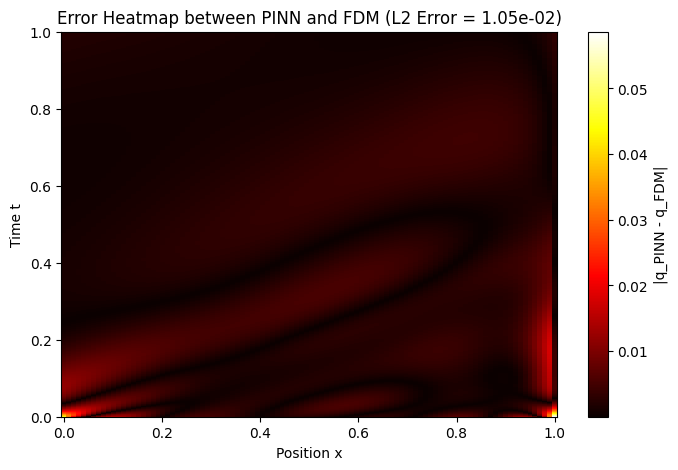

In [13]:
#block 11
import torch

# 🔁 Create meshgrid for PINN predictions over the same (t, x) domain
#    T_grid: time values repeated along rows, X_grid: space values repeated along columns
T_grid, X_grid = np.meshgrid(t, x, indexing='ij')  # shapes both (Nt+1, Nx)

# Stack the flattened (t, x) pairs into shape (Nt+1)*Nx × 2 for model input
tx_points = np.stack([T_grid.ravel(), X_grid.ravel()], axis=1)
# Convert to a torch tensor of type float32 and move to the compute device
tx_tensor = torch.tensor(tx_points, dtype=torch.float32).to(device)

# 📈 Switch model to evaluation mode (disables dropout, batch-norm stats updates)
model.eval()
with torch.no_grad():  # Disable gradient tracking for inference efficiency
    # Forward-pass the entire domain and reshape back to grid form
    q_pinn = model(tx_tensor).cpu().numpy().reshape(T_grid.shape)

# 📊 Compute the absolute pointwise error between PINN and FDM solutions
error_abs = np.abs(q_pinn - q_all)

# Compute the relative L2 error norm:
#   √(mean((q_pinn - q_FDM)²)) / √(mean(q_FDM²))
l2_error = np.sqrt(np.mean((q_pinn - q_all) ** 2)) / np.sqrt(np.mean(q_all ** 2))

# 🔥 Plot heatmap of absolute error over the (x, t) domain
plt.figure(figsize=(8, 5))
# Use pcolormesh for a colored quadrilateral grid; 'hot' colormap highlights large errors
plt.pcolormesh(X_grid, T_grid, error_abs, shading='auto', cmap='hot')
plt.colorbar(label='|q_PINN - q_FDM|')  # Show a legend for the error magnitude
plt.xlabel('Position x')                 # X-axis label
plt.ylabel('Time t')                     # Y-axis label
# Title includes the computed relative L2 error for quantitative context
plt.title(f"Error Heatmap between PINN and FDM (L2 Error = {l2_error:.2e})")
plt.show()  # Render the figure


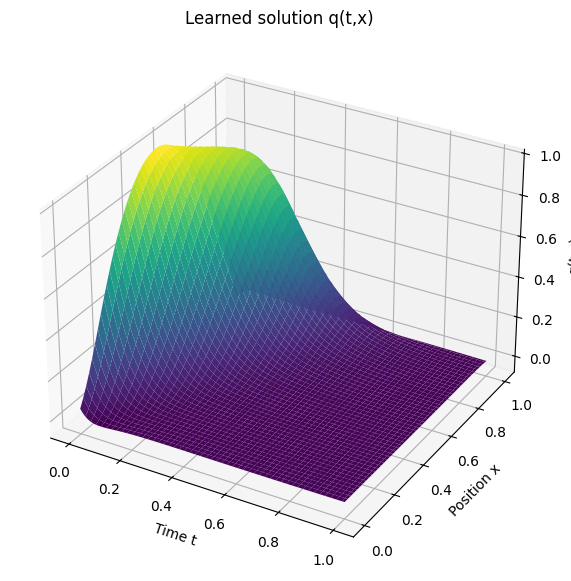

In [14]:
#block 11
import numpy as np

# Set model to evaluation mode (disables dropout, batch-norm updates)
model.eval()

# Create high-resolution 1D tensors for time and space in [0,1]
t_plot = torch.linspace(0, 1, 100).to(device)     # (100,) time points
x_plot = torch.linspace(0, 1, 100).to(device)     # (100,) spatial points

# Build a 2D meshgrid for plotting: Tg rows vary in time, Xg columns in space
T_plot, X_plot = torch.meshgrid(t_plot, x_plot, indexing='ij')  # both shape (100,100)

# Flatten the meshgrid into a list of (t,x) pairs: shape (10000,2)
tx_plot = torch.cat([
    T_plot.reshape(-1, 1),  # reshape time grid to (10000,1)
    X_plot.reshape(-1, 1)   # reshape space grid to (10000,1)
], dim=1)

# Predict q for all grid points without computing gradients
with torch.no_grad():
    q_plot = model(tx_plot)         # output shape (10000,1)
# Bring predictions to CPU and reshape back to 2D grid (100,100)
q_plot = q_plot.cpu().numpy().reshape(100, 100)

# Convert meshgrid coordinates to NumPy arrays for Matplotlib
T_plot = T_plot.cpu().numpy()      # time grid (100,100)
X_plot = X_plot.cpu().numpy()      # space grid (100,100)

# 📈 Plot the learned solution as a 3D surface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Render the surface: q_plot over (T_plot, X_plot)
ax.plot_surface(T_plot, X_plot, q_plot, cmap='viridis')

# Label axes and add title
ax.set_xlabel('Time t')            # X-axis label
ax.set_ylabel('Position x')        # Y-axis label
ax.set_zlabel('q(t,x)')            # Z-axis label for solution magnitude
ax.set_title('Learned solution q(t,x)')  # Descriptive title

plt.show()  # Display the figure


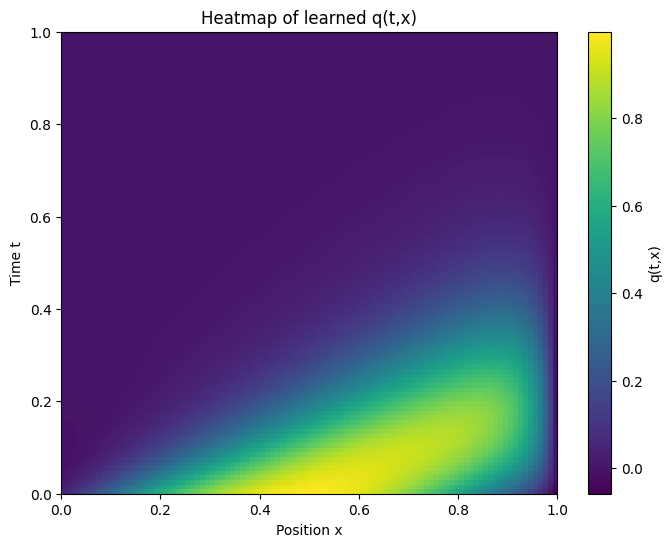

In [15]:
#block 12
# 🌡️ Heatmap visualization for the learned solution q(t,x) from the PINN

import matplotlib.pyplot as plt

# Create fine 1D tensors for time and space, each of length 100
# unsqueeze to shape (100,1) so meshgrid works correctly after squeezing
t_plot = torch.linspace(0, 1, 100, device=device).unsqueeze(1)  # time points in [0,1]
x_plot = torch.linspace(0, 1, 100, device=device).unsqueeze(1)  # spatial points in [0,1]

# Build a 2D grid of (t,x) pairs for plotting
# meshgrid returns two (100,100) tensors: t_plot_grid varies along rows, x_plot_grid along columns
t_plot_grid, x_plot_grid = torch.meshgrid(
    t_plot.squeeze(),   # shape back to (100,)
    x_plot.squeeze(),   # shape back to (100,)
    indexing='ij'       # ‘ij’ indexing to match matrix coords: first index for rows (time)
)

# Flatten the grid into shape (10000,2) for model input
tx_plot = torch.cat([
    t_plot_grid.reshape(-1, 1),  # flatten time grid to (10000,1)
    x_plot_grid.reshape(-1, 1)   # flatten space grid to (10000,1)
], dim=1)

# Predict q at each grid point, detach from graph and move to CPU
q_pred = model(tx_plot).detach().cpu().numpy()
# Reshape predictions back to 2D grid (100,100) for plotting
q_pred = q_pred.reshape(100, 100)

# Plot the heatmap of q(t,x)
plt.figure(figsize=(8, 6))
# imshow displays data on a 2D regular raster
# extent: [x_min, x_max, t_min, t_max], origin='lower' aligns t=0 at bottom
plt.imshow(
    q_pred,
    extent=[0, 1, 0, 1],
    origin='lower',
    aspect='auto',     # automatic aspect ratio
    cmap='viridis'     # perceptually-uniform colormap
)
plt.colorbar(label='q(t,x)')        # color scale legend
plt.xlabel('Position x')            # x-axis label
plt.ylabel('Time t')                # y-axis label
plt.title('Heatmap of learned q(t,x)')  # plot title
plt.show()  # render the heatmap


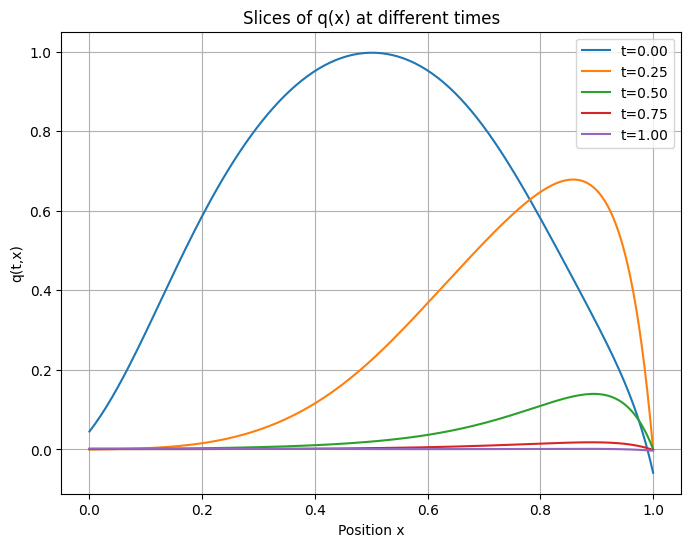

In [16]:
#block 13
# 📈 Plot 1D slices of the learned solution q(x) at specified time points

# List of time instants where we want to inspect q(x)
times_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0]  # in normalized units [0,1]

# Create a fine spatial grid of 200 points in [0,1] for smooth curves
# unsqueeze to shape (200,1) so it can be concatenated with time tensor
x_fine = torch.linspace(0, 1, 200, device=device).unsqueeze(1)

# Initialize a Matplotlib figure with a specified size
plt.figure(figsize=(8, 6))

# Loop over each desired time value to generate and plot the corresponding slice
for t_val in times_to_plot:
    # Create a tensor of the same shape as x_fine filled with the current time t_val
    # This results in a (200,1) tensor where every entry is t_val
    t_tensor = torch.full_like(x_fine, t_val)

    # Concatenate time and space into shape (200,2) for model input
    # Each row of tx_input is a point (t_val, x_i)
    tx_input = torch.cat([t_tensor, x_fine], dim=1)

    # Predict q at these (t, x) pairs, detach from computation graph, and move to CPU
    q_slice = model(tx_input).detach().cpu().numpy()

    # Plot q versus x for this time slice, labeling the line with the time value
    plt.plot(x_fine.cpu().numpy(), q_slice, label=f't={t_val:.2f}')

# Label axes and add a title for clarity
plt.xlabel('Position x')
plt.ylabel('q(t,x)')
plt.title('Slices of q(x) at different times')

# Add legend to distinguish curves at different times
plt.legend()

# Enable grid for easier reading of the plot
plt.grid(True)

# Render the plot to screen
plt.show()


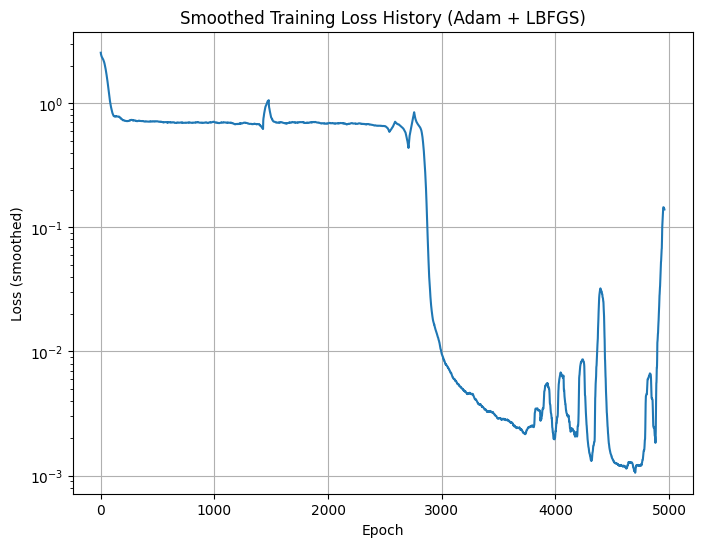

In [18]:
#block 14
import numpy as np

# Concatenate the loss histories from the Adam and LBFGS stages
# This creates a single timeline of training loss values for analysis
full_loss_history = loss_history_adam + loss_history_lbfgs

# Define a helper to compute a moving average for smoothing
def moving_average(data, window_size=50):
    """
    Smooth noisy data by averaging over a sliding window.

    Args:
        data (list or ndarray): Sequence of loss values.
        window_size (int): Number of points in each averaging window.

    Returns:
        ndarray: Smoothed loss values, length = len(data) - window_size + 1.
    """
    # Create a uniform window of length `window_size` and convolve with the data
    # mode='valid' ensures only complete window overlaps are used
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Apply the moving average to the combined loss history to reduce high-frequency noise
smoothed_loss = moving_average(full_loss_history, window_size=50)

# Plot the smoothed training loss over epochs
plt.figure(figsize=(8,6))
plt.plot(smoothed_loss)                      # Plot the loss curve
plt.xlabel('Epoch')                          # Label for the x-axis (training iteration)
plt.ylabel('Loss (smoothed)')                # Label for the y-axis (loss value)
plt.title('Smoothed Training Loss History (Adam + LBFGS)')  # Descriptive title
plt.yscale('log')                            # Use logarithmic scale to capture orders-of-magnitude changes
plt.grid(True)                               # Enable grid lines for better readability
plt.show()                                   # Display the figure


L2 Error between PINN and True Solution: 3.729723e-01


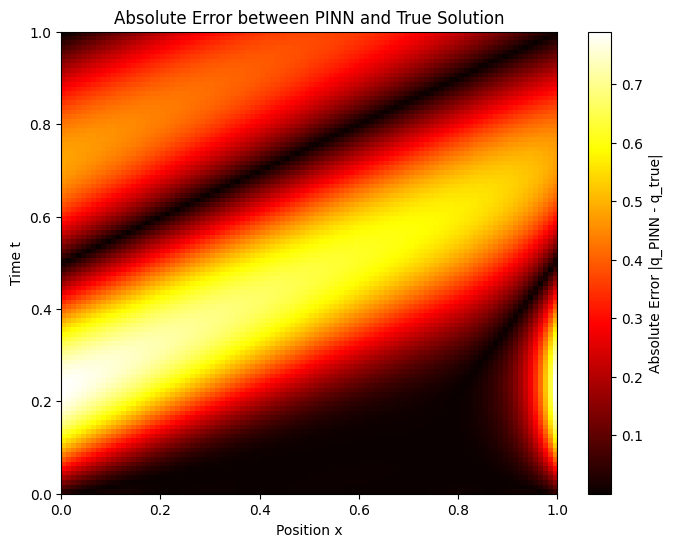

In [20]:
#block 15
import numpy as np

# Define the exact analytical solution for the advection–diffusion PDE:
# q_true(t,x) = exp(−D π² t) · sin[π (x − v t)]
def true_solution(t, x, v=2.0, D=0.1):
    return np.exp(-D * (np.pi**2) * t) * np.sin(np.pi * (x - v * t))

# Create a fine testing grid for time and space, each with 100 points in [0,1]
# unsqueeze to shape (100,1) so meshgrid works correctly after squeezing
t_test = torch.linspace(0, 1, 100, device=device).unsqueeze(1)  # (100,1)
x_test = torch.linspace(0, 1, 100, device=device).unsqueeze(1)  # (100,1)

# Build a 2D meshgrid for evaluation: T_test and X_test are both (100,100)
T_test, X_test = torch.meshgrid(
    t_test.squeeze(),   # shape back to (100,)
    x_test.squeeze(),   # shape back to (100,)
    indexing='ij'       # match matrix indexing
)

# Flatten the grids into column vectors of length 10,000 for model input
t_test_flat = T_test.reshape(-1, 1)  # (10000,1)
x_test_flat = X_test.reshape(-1, 1)  # (10000,1)

# Evaluate the trained PINN on the test grid
model.eval()  # switch to eval mode
tx_test_input = torch.cat([t_test_flat, x_test_flat], dim=1)  # (10000,2)
with torch.no_grad():
    q_pred_test = model(tx_test_input).cpu().numpy().flatten()  # (10000,)

# Compute the true solution on the same points using NumPy
t_np = t_test_flat.cpu().numpy().flatten()  # (10000,)
x_np = x_test_flat.cpu().numpy().flatten()  # (10000,)
q_true = true_solution(t_np, x_np)         # (10000,)

# Compute the global L2 error norm between PINN and true solution:
# sqrt(mean((q_pred - q_true)^2))
l2_error = np.sqrt(np.mean((q_pred_test - q_true)**2))
print(f"L2 Error between PINN and True Solution: {l2_error:.6e}")

# Reshape the pointwise absolute error back to a (100,100) grid for plotting
error_grid = np.abs(q_pred_test - q_true).reshape(100, 100)

# Plot the absolute error heatmap over (x,t) domain
plt.figure(figsize=(8, 6))
# imshow with 'hot' colormap highlights regions of high error
plt.imshow(
    error_grid,
    extent=[0, 1, 0, 1],    # [x_min, x_max, t_min, t_max]
    origin='lower',         # align t=0 at bottom
    aspect='auto',
    cmap='hot'
)
plt.colorbar(label='Absolute Error |q_PINN - q_true|')  # show error scale
plt.xlabel('Position x')   # x-axis label
plt.ylabel('Time t')       # y-axis label
plt.title('Absolute Error between PINN and True Solution')  # title
plt.show()  # render the heatmap


In [21]:
#block 16  — FD vs PINN error comparison on the same grid

# (1) Retrieve the classical finite-difference solution and the meshgrid
#     Q_fd: array of shape (Nt+1, Nx) from the FD solver (q_all)
#     Xg, Tg: meshgrid arrays of shape (Nt+1, Nx) from Block 9
Q_fd   = q_all.copy()       # Copy to avoid modifying q_all
Xg, Tg = X_grid, T_grid     # Spatial and temporal grids for comparison

# (2) Evaluate the trained PINN on the identical (t,x) grid
#     - Flatten Tg and Xg into an (Nt+1)*Nx × 2 array of (t,x) pairs
#     - Convert to a float32 tensor on the compute device for inference
tx = torch.tensor(
    np.stack([Tg.ravel(), Xg.ravel()], axis=1),  # stack time and space coordinates
    dtype=torch.float32,
).to(device)
with torch.no_grad():  # disable gradient calculation for speed and memory
    # Forward pass: predict q at each grid point and reshape back to (Nt+1, Nx)
    Q_pinn_on_fd = model(tx).cpu().numpy().reshape(Tg.shape)

# (3) Compute the exact analytical solution on the same grid:
#     q_true(t,x) = exp(−D π² t) * sin[π (x − v t)]
Q_true = np.exp(-D * (np.pi**2) * Tg) * np.sin(np.pi * (Xg - v * Tg))

# (4) Define a helper to compute L2 and L∞ error norms between two solutions
def compute_errors(A, B):
    """
    Args:
        A, B (ndarray): solution arrays of identical shape.

    Returns:
        L2   : Root-mean-square error = ||A−B||₂ / sqrt(N_total)
        Linf : Maximum absolute error = max|A−B|
    """
    L2   = np.linalg.norm(A - B) / np.sqrt(A.size)   # normalized L2 norm
    Linf = np.max(np.abs(A - B))                    # maximum pointwise error
    return L2, Linf

# Compute error metrics for FD and PINN against the true solution
err_fd   = compute_errors(Q_fd,   Q_true)
err_pinn = compute_errors(Q_pinn_on_fd, Q_true)

# Print the comparative errors with scientific formatting
print(f"FD   : L2={err_fd[0]:.2e}, L∞={err_fd[1]:.2e}")
print(f"PINN : L2={err_pinn[0]:.2e}, L∞={err_pinn[1]:.2e}")


FD   : L2=3.74e-01, L∞=7.91e-01
PINN : L2=3.74e-01, L∞=7.90e-01


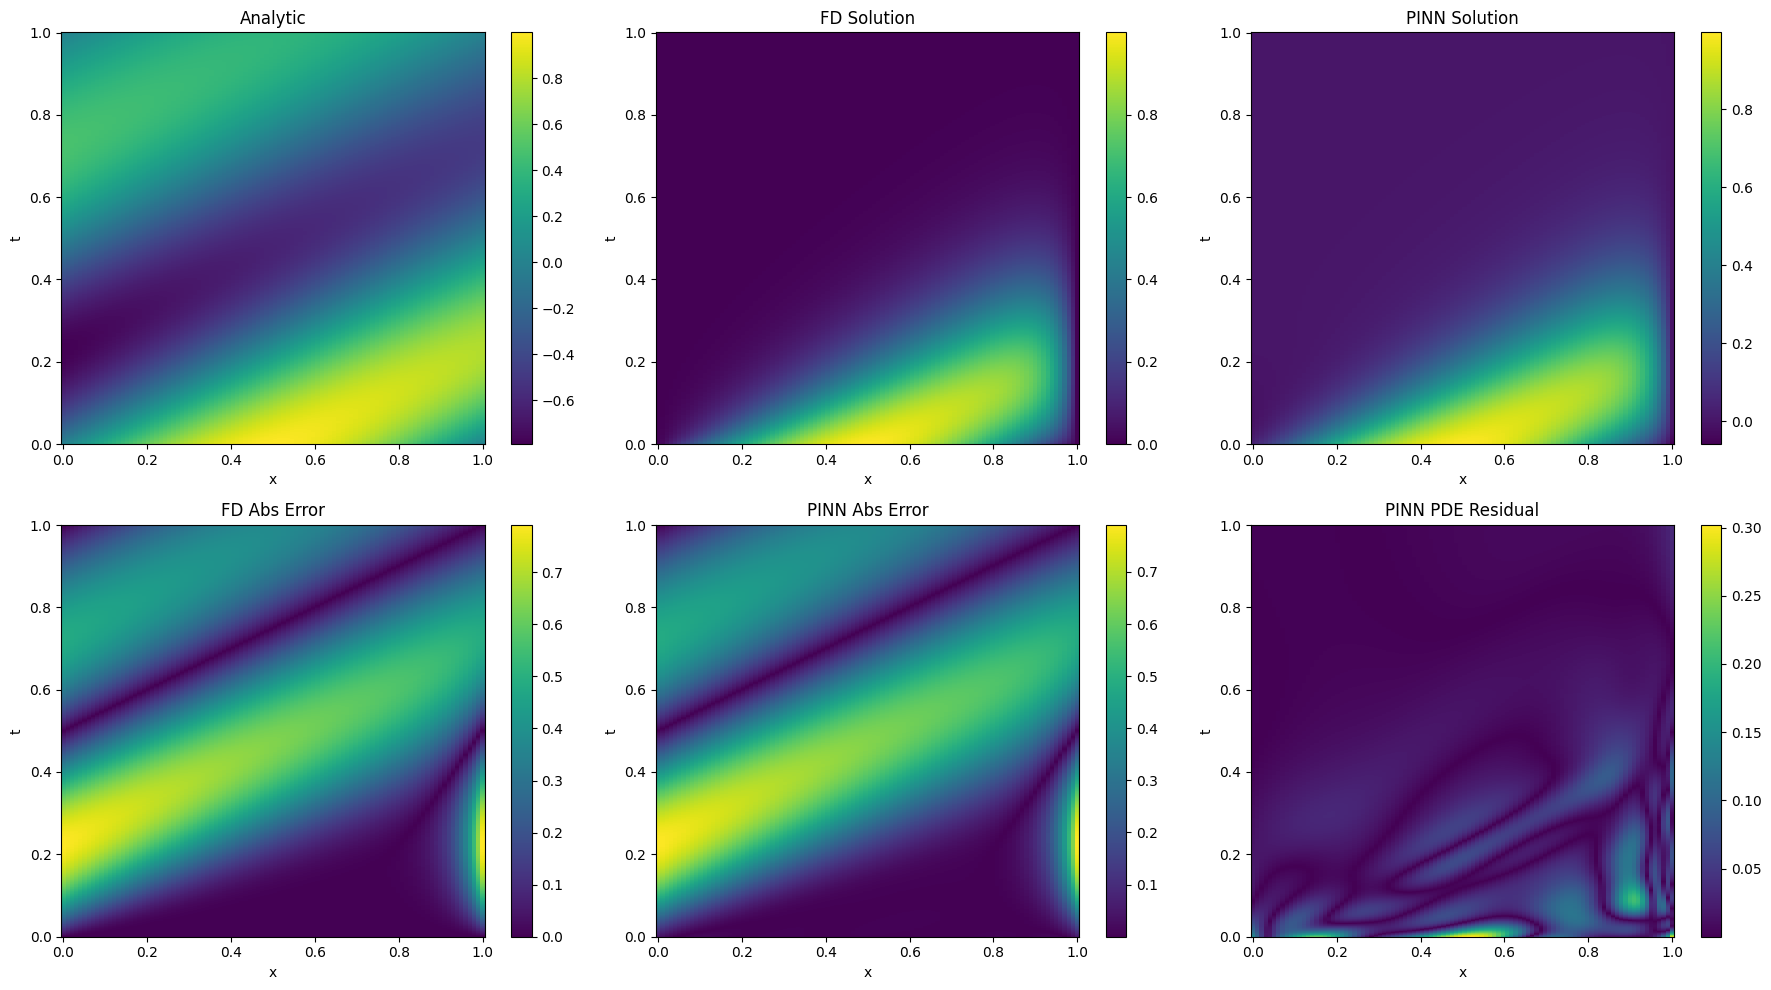

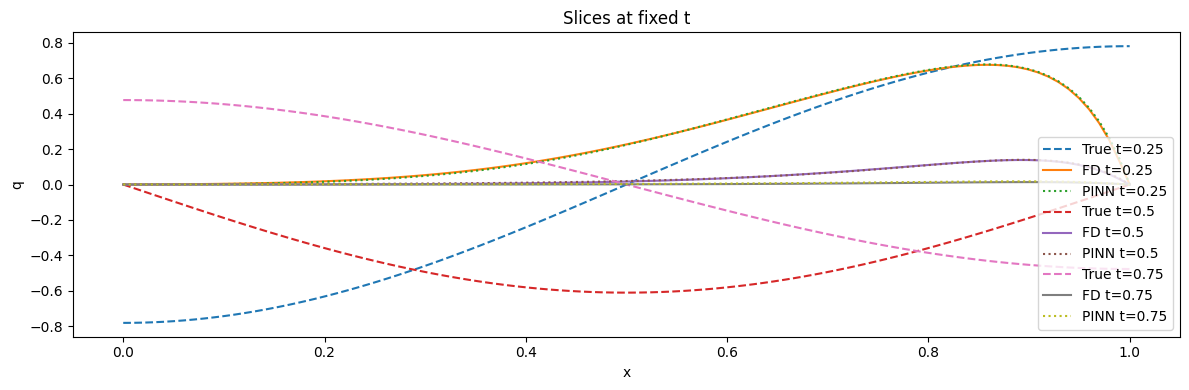

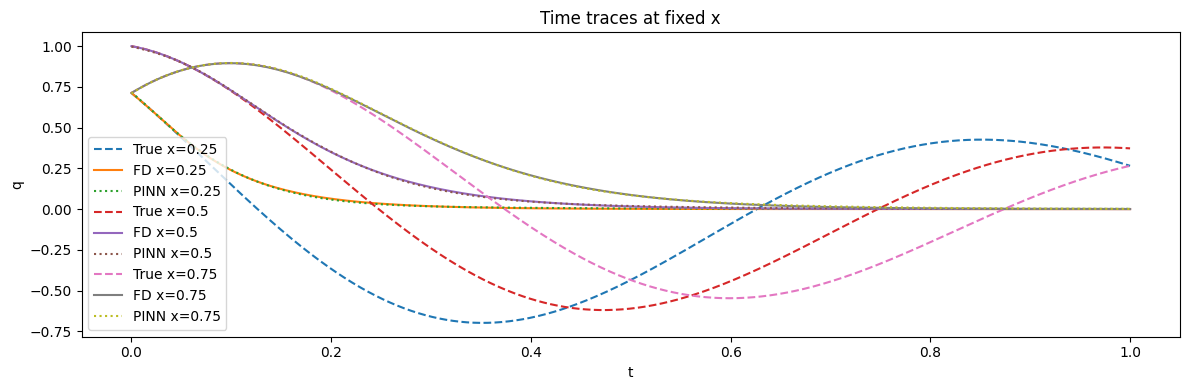

In [23]:
# block 17 — Fast PINN residual + 2×3 heatmaps + slice plots

import numpy as np
import matplotlib.pyplot as plt
import torch

# 1) Compute pointwise absolute errors for FD and PINN against the analytic solution
err_fd   = np.abs(Q_fd   - Q_true)           # |q_FD − q_true|
err_pinn = np.abs(Q_pinn_on_fd - Q_true)     # |q_PINN − q_true|

# 2) Prepare float32 torch tensor of all (t,x) points for gradient computation
T_flat = Tg.ravel().astype(np.float32)       # Flatten time grid to 1D array
X_flat = Xg.ravel().astype(np.float32)       # Flatten space grid to 1D array
tx_all = torch.tensor(
    np.stack([T_flat, X_flat], axis=1),      # Stack into shape (N,2) for N points
    device=device, requires_grad=True,       # Enable gradient tracking on input
)

# 3) Evaluate PINN and compute first-order derivatives ∂q/∂t and ∂q/∂x
q_pred = model(tx_all)                       # PINN predictions shape (N,1)
grads  = torch.autograd.grad(
    q_pred, tx_all,
    grad_outputs=torch.ones_like(q_pred),    # Seed vector for vector-Jacobian product
    create_graph=True,                       # Retain graph for higher-order gradients
)[0]                                         # grads shape (N,2)
q_t = grads[:, 0]                            # ∂q/∂t for each point (shape N,)
q_x = grads[:, 1]                            # ∂q/∂x for each point (shape N,)

# 4) Compute second spatial derivative ∂²q/∂x² in a vectorized manner
grads2 = torch.autograd.grad(
    q_x.unsqueeze(1), tx_all,                # Differentiate q_x w.r.t. (t,x)
    grad_outputs=torch.ones_like(q_x).unsqueeze(1),
    create_graph=False,                      # No need for higher-order derivatives here
)[0]                                         # grads2 shape (N,2)
q_xx = grads2[:, 1]                          # Extract ∂²q/∂x² (shape N,)

# 5) Detach derivatives, reshape to grid, and compute PINN PDE residual
q_t_np   = q_t.detach().cpu().numpy().reshape(Tg.shape)    # (Nt+1, Nx)
q_xx_np  = q_xx.detach().cpu().numpy().reshape(Tg.shape)   # (Nt+1, Nx)
# Residual R = ∂q/∂t + v∂q/∂x − D∂²q/∂x², take absolute value
res_pinn = np.abs(
    q_t_np + v * q_x.detach().cpu().numpy().reshape(Tg.shape)
    - D * q_xx_np
)

# 6) Create a 2×3 panel of heatmaps for solutions and errors
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
maps = [
    (Q_true,       "Analytic"),            # Exact solution
    (Q_fd,         "FD Solution"),         # Finite-difference result
    (Q_pinn_on_fd, "PINN Solution"),       # PINN result
    (err_fd,       "FD Abs Error"),        # |FD − true|
    (err_pinn,     "PINN Abs Error"),      # |PINN − true|
    (res_pinn,     "PINN PDE Residual"),   # |∂q/∂t + v∂q/∂x − D∂²q/∂x²|
]
for ax, (data, title) in zip(axs.flatten(), maps):
    im = ax.pcolormesh(Xg, Tg, data, shading='auto')  # Colored mesh of data
    ax.set_title(title)                               # Subplot title
    ax.set_xlabel("x")                                # x-axis label
    ax.set_ylabel("t")                                # y-axis label
    fig.colorbar(im, ax=ax)                           # Colorbar for each heatmap
plt.tight_layout()                                    # Adjust spacing

# 7) Plot 1D slices at fixed times to compare profiles
times = [0.25, 0.5, 0.75]                            # Chosen time instants
i_t   = [np.argmin(np.abs(t - time)) for time in times]  # Find nearest time indices
plt.figure(figsize=(12, 4))
for idx, time in zip(i_t, times):
    plt.plot(x, Q_true[idx],    '--', label=f"True t={time}")    # Analytic slice
    plt.plot(x, Q_fd[idx],       '-', label=f"FD t={time}")      # FD slice
    plt.plot(x, Q_pinn_on_fd[idx],':', label=f"PINN t={time}")   # PINN slice
plt.title("Slices at fixed t")                       # Plot title
plt.xlabel("x")                                      # x-axis label
plt.ylabel("q")                                      # y-axis label
plt.legend()                                         # Show legend
plt.tight_layout()                                   # Adjust spacing

# 8) Plot time traces at fixed spatial positions to compare temporal evolution
positions = [0.25, 0.5, 0.75]                        # Spatial locations of interest
i_x = [np.argmin(np.abs(x - pos)) for pos in positions]  # Nearest x-indices
plt.figure(figsize=(12, 4))
for ix, pos in zip(i_x, positions):
    plt.plot(t, Q_true[:, ix],    '--', label=f"True x={pos}")    # Analytic over time
    plt.plot(t, Q_fd[:, ix],       '-', label=f"FD x={pos}")      # FD over time
    plt.plot(t, Q_pinn_on_fd[:, ix],':', label=f"PINN x={pos}")  # PINN over time
plt.title("Time traces at fixed x")                  # Plot title
plt.xlabel("t")                                      # x-axis label is time
plt.ylabel("q")                                      # y-axis label is solution
plt.legend()                                         # Show legend
plt.tight_layout()                                   # Adjust spacing
